In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
df = pd.read_json("results.jsonl", lines=True)
print(len(df))
df.head()

66


,id,name,params.train.dataset.path,params.train.dataset.name,params.train.dataset.split,params.train.optimizer,params.evaluation.dataset.path,params.evaluation.dataset.name,params.evaluation.dataset.split,params.qa.model,...,params.qa.technique,params.run,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
0,fd86cf5845c0ae8b1da87da91b5e35877f714143,rowdy-bice,bdsaglam/musique-mini,answerable,train,bfsrs-medium,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,...,cte,3,0.636326,0.753993,0.655751,0.774965,0.635526,0.757498,0.577778,0.682584
1,d54e170d01bd6a67c42f39fbd553231cbde4a78b,hated-lots,bdsaglam/musique-mini,answerable,train,bfsrs-medium,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,...,cte,2,0.629293,0.751144,0.653355,0.774040,0.613158,0.755193,0.585185,0.672767
2,ea6a5cd017ad77243f6ab6c61200cbb875e207e3,faced-whop,bdsaglam/musique-mini,answerable,train,bfsrs-medium,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,...,cte,1,0.646256,0.765575,0.669329,0.786556,0.639474,0.770381,0.587654,0.691696
3,b5bf482a16c39fce546feeb86d51c4802174d89b,moldy-coat,bdsaglam/musique-mini,answerable,train,bfsrs-medium,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,...,cte,3,0.633430,0.753569,0.660543,0.779471,0.631579,0.769310,0.553086,0.643956
4,e719c964876eef2ae1738013e32bbad8454d2636,sedgy-rubs,bdsaglam/musique-mini,answerable,train,bfsrs-medium,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,...,cte,2,0.640877,0.761151,0.668530,0.783167,0.640789,0.783266,0.555556,0.651593


In [3]:
param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]

In [4]:
for col in param_cols:
    print(col)
    print(df[col].unique())

params.train.dataset.path
['bdsaglam/musique-mini']
params.train.dataset.name
['answerable']
params.train.dataset.split
['train']
params.train.optimizer
['bfsrs-medium']
params.evaluation.dataset.path
['bdsaglam/musique']
params.evaluation.dataset.name
['answerable']
params.evaluation.dataset.split
['validation']
params.qa.model
['llama-3-70b-tgi']
params.qa.temperature
[0.7 0.5 0.1]
params.qa.technique
['cte' 'cot' 'standard' 'ccot']
params.run
[3 2 1 6 5 4]


In [5]:
df.drop(
    columns=[
        "id",
        "name",
        "params.train.dataset.path",
        "params.train.dataset.name",
        "params.train.dataset.split",
        "params.train.optimizer",
        "params.evaluation.dataset.path",
        "params.evaluation.dataset.name",
        "params.evaluation.dataset.split",
        "params.qa.model",
    ],
    inplace=True,
)

In [6]:
target_param_cols = [
    "params.qa.technique",
    "params.qa.temperature",
]
df = df.sort_values(target_param_cols + ["params.run"])
df.reset_index(drop=True, inplace=True)

In [7]:
run_counts = df.groupby(target_param_cols)["params.run"].aggregate(tuple).reset_index()
mask = run_counts["params.run"].map(len) < 6
run_counts.loc[mask]

,params.qa.technique,params.qa.temperature,params.run


In [8]:
df[target_param_cols + metric_cols].sort_values('metrics.f1', ascending=False).head(10)

,params.qa.technique,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
42,cte,0.7,0.646256,0.765575,0.669329,0.786556,0.639474,0.770381,0.587654,0.691696
33,cte,0.1,0.646256,0.764837,0.677316,0.792663,0.635526,0.775002,0.570370,0.659741
32,cte,0.1,0.645428,0.764044,0.678914,0.793158,0.632895,0.771048,0.565432,0.660897
35,cte,0.1,0.645842,0.764003,0.676518,0.793353,0.635526,0.768980,0.570370,0.663931
34,cte,0.1,0.644601,0.762653,0.675719,0.790826,0.634211,0.769975,0.567901,0.661816
30,cte,0.1,0.644187,0.761736,0.673323,0.787970,0.638158,0.767011,0.565432,0.670738
37,cte,0.5,0.640877,0.761151,0.668530,0.783167,0.640789,0.783266,0.555556,0.651593
39,cte,0.5,0.639222,0.761092,0.659744,0.780174,0.644737,0.781515,0.565432,0.663775
45,cte,0.7,0.635085,0.756837,0.660543,0.779869,0.630263,0.760915,0.565432,0.677988
47,cte,0.7,0.635085,0.756307,0.655751,0.773142,0.631579,0.765718,0.577778,0.686602


In [9]:
avg_df = df.groupby(target_param_cols)[metric_cols].mean().reset_index()
avg_df.head()

,params.qa.technique,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
0,ccot,0.1,0.623500,0.736378,0.645767,0.759137,0.634868,0.759171,0.533333,0.623248
1,ccot,0.5,0.612054,0.733461,0.633120,0.753135,0.619298,0.752339,0.533333,0.637216
2,cot,0.1,0.614743,0.733813,0.640442,0.757710,0.623465,0.760425,0.518930,0.610000
3,cot,0.5,0.616674,0.731874,0.634851,0.755068,0.628947,0.749670,0.537449,0.626777
4,cot,0.7,0.622259,0.739113,0.640708,0.758467,0.638596,0.763635,0.534568,0.633263


In [10]:
# find the rows with max f1 score for each technique group
max_f1_rows = avg_df.groupby('params.qa.technique')["metrics.f1"].idxmax()
best_df = avg_df.loc[max_f1_rows, target_param_cols + metric_cols].sort_values('metrics.f1', ascending=False)
best_df

,params.qa.technique,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
5,cte,0.1,0.644325,0.762108,0.676251,0.790169,0.633991,0.769386,0.565021,0.661703
4,cot,0.7,0.622259,0.739113,0.640708,0.758467,0.638596,0.763635,0.534568,0.633263
8,standard,0.1,0.611571,0.736477,0.641906,0.769197,0.600439,0.735092,0.538683,0.637925
0,ccot,0.1,0.623500,0.736378,0.645767,0.759137,0.634868,0.759171,0.533333,0.623248


## Visualizations

In [11]:
def prepare_data(dataf):
    # Simplify column names for use in formula
    dataf = dataf[target_param_cols + ['params.run'] + metric_cols[:2]].rename(
        columns={
            col: col.replace("params.qa.", "").replace("params.", "").replace("metrics.", "")
            for col in dataf.columns
        }
    )
    return dataf


In [12]:
def plot_variance(dataf, figsize=(12, 6), legend='auto', legend_loc='lower left'):  
    plt.figure(figsize=figsize)
    sns.lineplot(x='temperature', y='f1', hue='technique', data=dataf, linewidth=2.5, legend=legend)
    plt.title("F1 Scores by Prompt and Temperature")
    plt.xlabel("Temperature")
    plt.ylabel("F1 Score")
    if legend:
        plt.legend(loc=legend_loc)
    plt.tight_layout()
    plt.show()

In [13]:
prepared_df = prepare_data(df)
temperature_mask = prepared_df["temperature"] <= 1.0
prepared_df

,technique,temperature,run,exact_match,f1
0,ccot,0.1,1,0.620604,0.729279
1,ccot,0.1,2,0.624328,0.739143
2,ccot,0.1,3,0.625983,0.734520
3,ccot,0.1,4,0.622259,0.739558
4,ccot,0.1,5,0.623914,0.738124
...,...,...,...,...,...
61,standard,0.7,2,0.615639,0.730054
62,standard,0.7,3,0.610674,0.732615
63,standard,0.7,4,0.609433,0.734266
64,standard,0.7,5,0.612329,0.734358


## Statistical Testing

In [14]:
def two_way_anova(dataf):
    if dataf.empty:
        raise ValueError("No data to perform ANOVA")
    # Perform Two-Way ANOVA with replication
    formula = "f1 ~ C(technique) + C(temperature) + C(technique):C(temperature)"
    model = ols(formula, data=dataf).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("Two-Way ANOVA Results:")
    print(anova_table)


def one_way_anova_by_temperature(dataf):
    if dataf.empty:
        raise ValueError("No data to perform ANOVA")
    # Perform One-Way ANOVA at each temperature
    temperatures = dataf["temperature"].unique()
    for temp in temperatures:
        temp_data = dataf[dataf["temperature"] == temp]
        grouped = temp_data.groupby("technique")["f1"].apply(list).reset_index()
        f1_scores = grouped["f1"]

        if len(f1_scores) < 2:
            print(f"Skipping temperature {temp}: Not enough groups to perform ANOVA")
            continue

        anova_result = f_oneway(*f1_scores)
        print(f"One-Way ANOVA for Temperature {temp:.1f}:")
        print(
            f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}"
        )

In [15]:
def report(dataf, alpha=0.05):
    print("\n")
    print("Temperature values: ", ', '.join([f"{t:.1f}" for t in dataf.temperature.unique()]))
    print("\n")
    # Two-Way ANOVA
    two_way_anova(dataf)
    print("\n")
    
    # One-Way ANOVA by Temperature
    one_way_anova_by_temperature(dataf)
    print("\n")
    
    # Tukey’s HSD
    tukey = pairwise_tukeyhsd(endog=dataf['f1'], groups=dataf['technique'], alpha=alpha)
    print(tukey)

### All techniques

In [16]:
report(prepared_df)



Temperature values:  0.1, 0.5, 0.7


Two-Way ANOVA Results:
                               sum_sq    df           F        PR(>F)
C(technique)                 0.007970   3.0  165.248065  1.737083e-27
C(temperature)               0.000526   2.0   16.364316  2.652081e-06
C(technique):C(temperature)  0.000410   6.0    4.251816  1.379391e-03
Residual                     0.000884  55.0         NaN           NaN


One-Way ANOVA for Temperature 0.1:
F-statistic: 66.1590, p-value: 1.4642e-10
One-Way ANOVA for Temperature 0.5:
F-statistic: 79.3471, p-value: 2.7910e-11
One-Way ANOVA for Temperature 0.7:
F-statistic: 46.3070, p-value: 3.8165e-07




 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
  ccot      cot      0.0    1.0 -0.0053  0.0053  False
  ccot      cte   0.0233    0.0   0.018  0.0286   True
  ccot standard  -0.0036 0.2975 -0.0089  0.0018  False
   cot      cte   0.0233    0.0  0.0185  0.0281   True
   cot standard  -0.0036 0.2042 -0.0084  0.0012  False
   cte standard  -0.0269    0.0 -0.0317 -0.0221   True
------------------------------------------------------


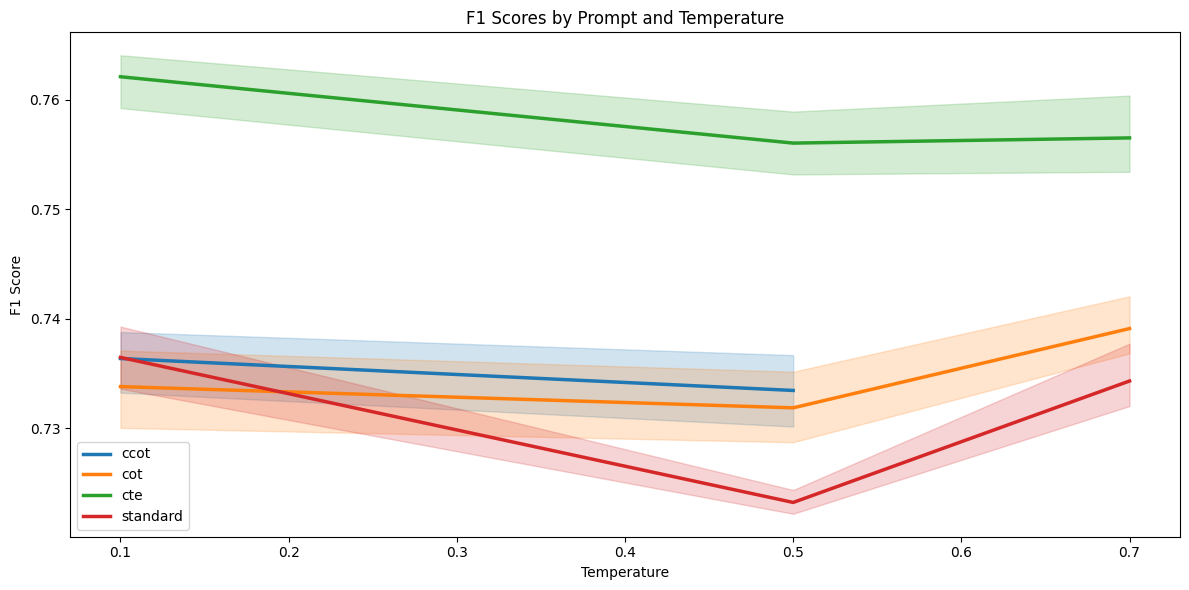

In [17]:
plot_variance(prepared_df)

## Inspect

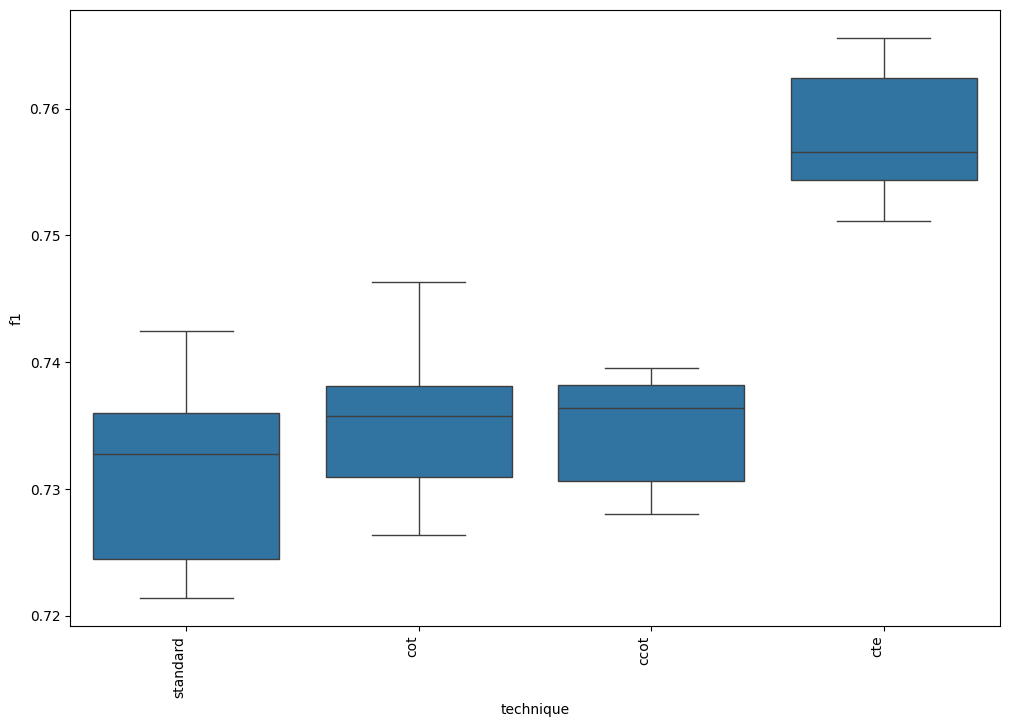

In [18]:
# box-whisker plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    x="technique",
    y="f1",
    data=prepared_df.loc[temperature_mask].sort_values(by="f1"),
)
plt.xticks(rotation=90, ha="right");